# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf
import numpy as np

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier labs, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

This lab can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [4]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


# Functions

## To Window Function

In [5]:
# Let's make our own function to_windows(dataset, length)

def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

## Fit and Evaluate Function

In [30]:
# Let's define a utility function we'll reuse several times
import time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    start_time = time.time()
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    end_time = time.time()
    elapsed_time = end_time - start_time
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6, history, elapsed_time

## Seq to seq function

In [7]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

# Data Preprocessing

In [8]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [9]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

In [10]:
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [11]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

# Multivariate time series

In [12]:
# First creat the dataset with the bus and rail information
# Scale (1e6)

df_mulvar = df[["bus", "rail"]] / 1e6

# Insert in the dataset the "next_day_type" column

df_mulvar["next_day_type"] = df["day_type"].shift(-11)

df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [13]:
# Let's split our dataset - train, validation, and test sets

mulvar_train = df_mulvar["2016-01":"2018-12"]

mulvar_valid = df_mulvar["2019-01":"2019-05"]

mulvar_test = df_mulvar["2019-06":]

In [14]:
# Let's take a look at our training set

mulvar_train

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2016-01-01,0.303321,0.319835,0,0,1
2016-01-02,0.448859,0.365509,0,0,1
2016-01-03,0.340540,0.287661,0,0,1
2016-01-04,0.829429,0.703185,0,0,1
2016-01-05,0.846789,0.727716,1,0,0
...,...,...,...,...,...
2018-12-27,0.509948,0.453029,0,0,1
2018-12-28,0.577497,0.493961,0,0,1
2018-12-29,0.394088,0.307105,0,0,1


train_mulvar_ds and valid_mulvar_ds

In [15]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

seq_length = 56
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [16]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

# Expects input sequences of shape [None, 5]
# First SimpleRNN layer with 50 neurons - Returns the full sequence of outputs to the next layer
# Second SimpleRNN layer with 50 neurons - Returns the full sequence of outputs to the next layer
# Third SimpleRNN layer with 50 neurons - Returns the full sequence of outputs to the next layer
# Fourth SimpleRNN layer with 50 neurons
# Dense layer with 1 neuron for the final output

### your code
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.SimpleRNN(50, return_sequences=True),
    tf.keras.layers.SimpleRNN(50, return_sequences=True),
    tf.keras.layers.SimpleRNN(50, return_sequences=True),
    tf.keras.layers.SimpleRNN(50),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [17]:
mae, history, time = fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.05, epochs=500)

Epoch 1/500
33/33 [==============================] - 8s 95ms/step - loss: 0.0605 - mae: 0.2665 - val_loss: 0.0162 - val_mae: 0.1402
Epoch 2/500
33/33 [==============================] - 5s 140ms/step - loss: 0.0200 - mae: 0.1669 - val_loss: 0.0158 - val_mae: 0.1453
Epoch 3/500
33/33 [==============================] - 6s 192ms/step - loss: 0.0209 - mae: 0.1703 - val_loss: 0.0306 - val_mae: 0.2311
Epoch 4/500
33/33 [==============================] - 4s 108ms/step - loss: 0.0297 - mae: 0.2032 - val_loss: 0.0308 - val_mae: 0.1742
Epoch 5/500
33/33 [==============================] - 2s 66ms/step - loss: 0.0214 - mae: 0.1705 - val_loss: 0.0297 - val_mae: 0.2284
Epoch 6/500
33/33 [==============================] - 4s 115ms/step - loss: 0.0316 - mae: 0.2067 - val_loss: 0.0444 - val_mae: 0.2405
Epoch 7/500
33/33 [==============================] - 2s 70ms/step - loss: 0.0200 - mae: 0.1660 - val_loss: 0.0151 - val_mae: 0.1434
Epoch 8/500
33/33 [==============================] - 2s 66ms/step - loss

In [25]:
print("Mae:" + mae + "\tTime:" + time)

(23436.548188328743, 771.1831459999084)

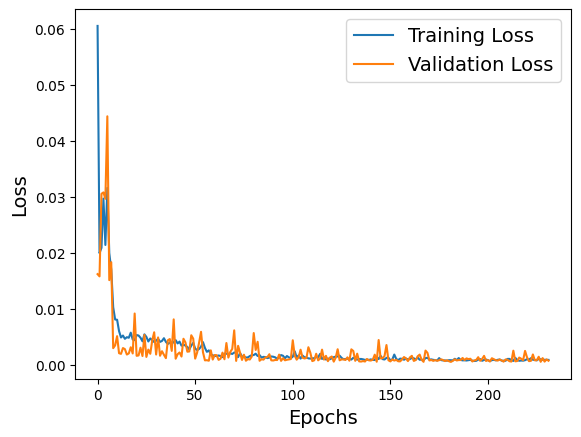

In [19]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Seq to Seq 14 Days Prediction

In [26]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

## Simple RNN

In [43]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

### your code
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(50, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)  # no activation function by default
])

In [44]:
seq_mae, seq_history, seq_time = fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 2s 30ms/step - loss: 0.0657 - mae: 0.2510 - val_loss: 0.0111 - val_mae: 0.1127
Epoch 2/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0072 - mae: 0.0879 - val_loss: 0.0058 - val_mae: 0.0738
Epoch 3/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0051 - mae: 0.0704 - val_loss: 0.0057 - val_mae: 0.0740
Epoch 4/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0044 - mae: 0.0636 - val_loss: 0.0043 - val_mae: 0.0570
Epoch 5/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0042 - mae: 0.0616 - val_loss: 0.0048 - val_mae: 0.0649
Epoch 6/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0039 - mae: 0.0589 - val_loss: 0.0045 - val_mae: 0.0604
Epoch 7/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0038 - mae: 0.0581 - val_loss: 0.0044 - val_mae: 0.0600
Epoch 8/500
33/33 [==============================] - 1s 32ms/step - loss: 0.

In [47]:
print("Mae:", seq_mae, "\tTime:", seq_time)

Mae: 44824.04142618179 	Time: 434.83240962028503


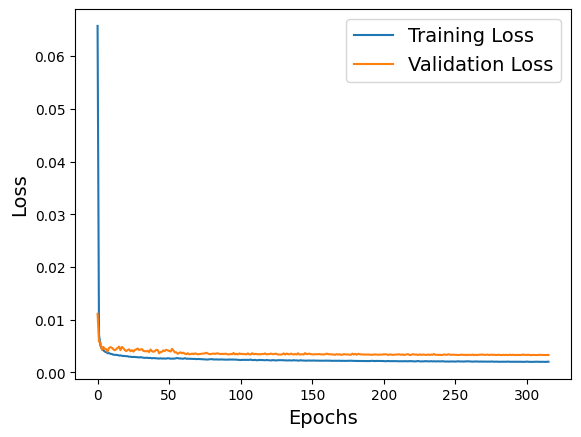

In [48]:
# Plot training and validation loss
plt.plot(seq_history.history['loss'], label='Training Loss')
plt.plot(seq_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output


1/1 [==============================] - 0s 193ms/step


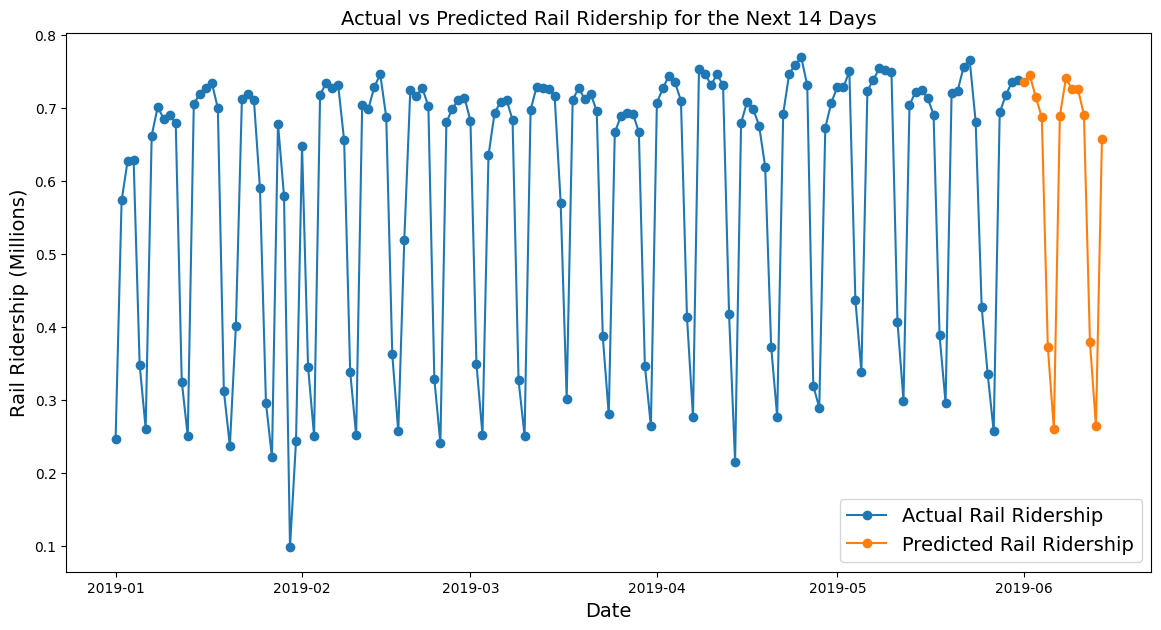

In [50]:
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(rail_valid.index, rail_valid.values, label='Actual Rail Ridership', marker='o')

# Plot predicted values for the next 14 days
predicted_dates = pd.date_range(start=rail_valid.index[-1] + pd.DateOffset(1), periods=14)
plt.plot(predicted_dates, y_pred_14, label='Predicted Rail Ridership', marker='o')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Rail Ridership (Millions)')
plt.title('Actual vs Predicted Rail Ridership for the Next 14 Days')

# Show legend
plt.legend()

# Show the plot
plt.show()

## LSTM

In [51]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [52]:
lstm_mae, lstm_history, lstm_time =fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=500)

Epoch 1/500
33/33 [==============================] - 4s 54ms/step - loss: 0.0518 - mae: 0.2497 - val_loss: 0.0188 - val_mae: 0.1681
Epoch 2/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0170 - mae: 0.1569 - val_loss: 0.0172 - val_mae: 0.1468
Epoch 3/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0154 - mae: 0.1505 - val_loss: 0.0165 - val_mae: 0.1404
Epoch 4/500
33/33 [==============================] - 2s 52ms/step - loss: 0.0146 - mae: 0.1457 - val_loss: 0.0158 - val_mae: 0.1358
Epoch 5/500
33/33 [==============================] - 2s 61ms/step - loss: 0.0138 - mae: 0.1413 - val_loss: 0.0150 - val_mae: 0.1326
Epoch 6/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0132 - mae: 0.1368 - val_loss: 0.0143 - val_mae: 0.1284
Epoch 7/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0125 - mae: 0.1331 - val_loss: 0.0139 - val_mae: 0.1236
Epoch 8/500
33/33 [==============================] - 1s 34ms/step - loss: 0.

In [53]:
print("Mae:", lstm_mae, "\tTime:", lstm_time)

Mae: 46779.45002913475 	Time: 982.0709455013275


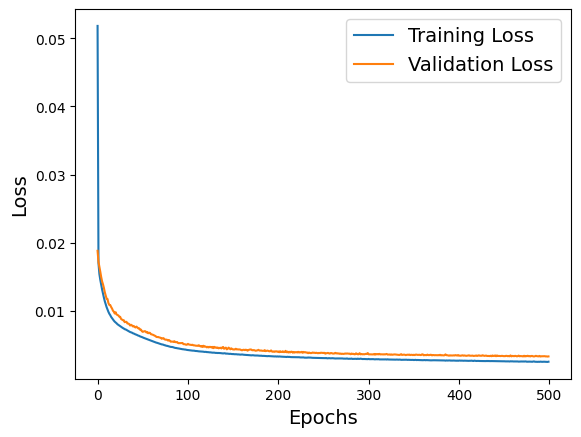

In [54]:
# Plot training and validation loss
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14_lstm = lstm_model.predict(X)[0, -1]  # only the last time step's output


1/1 [==============================] - 1s 620ms/step


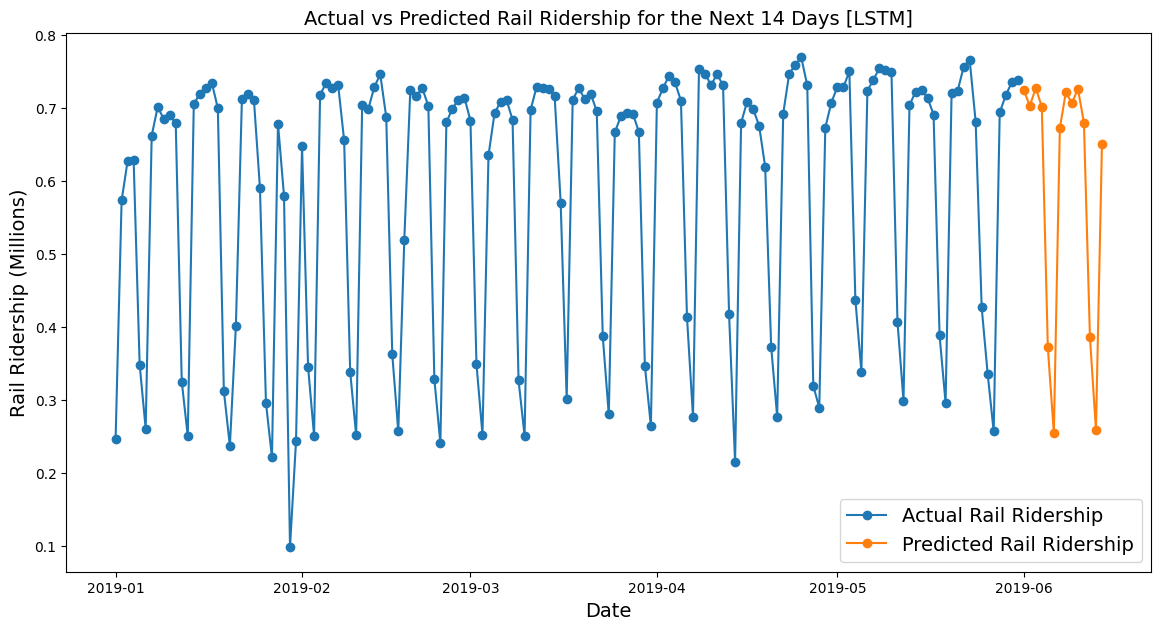

In [56]:
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(rail_valid.index, rail_valid.values, label='Actual Rail Ridership', marker='o')

# Plot predicted values for the next 14 days
predicted_dates = pd.date_range(start=rail_valid.index[-1] + pd.DateOffset(1), periods=14)
plt.plot(predicted_dates, y_pred_14_lstm, label='Predicted Rail Ridership', marker='o')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Rail Ridership (Millions)')
plt.title('Actual vs Predicted Rail Ridership for the Next 14 Days [LSTM]')

# Show legend
plt.legend()

# Show the plot
plt.show()

## GRUs

In [57]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(50, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [58]:
gru_mae, gru_history, gru_time = fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=500)

Epoch 1/500
33/33 [==============================] - 4s 52ms/step - loss: 0.0547 - mae: 0.2595 - val_loss: 0.0169 - val_mae: 0.1452
Epoch 2/500
33/33 [==============================] - 2s 55ms/step - loss: 0.0139 - mae: 0.1366 - val_loss: 0.0140 - val_mae: 0.1231
Epoch 3/500
33/33 [==============================] - 2s 58ms/step - loss: 0.0115 - mae: 0.1237 - val_loss: 0.0125 - val_mae: 0.1157
Epoch 4/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0105 - mae: 0.1163 - val_loss: 0.0118 - val_mae: 0.1106
Epoch 5/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0098 - mae: 0.1105 - val_loss: 0.0109 - val_mae: 0.1071
Epoch 6/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0093 - mae: 0.1069 - val_loss: 0.0104 - val_mae: 0.1041
Epoch 7/500
33/33 [==============================] - 2s 40ms/step - loss: 0.0089 - mae: 0.1035 - val_loss: 0.0101 - val_mae: 0.1024
Epoch 8/500
33/33 [==============================] - 1s 36ms/step - loss: 0.

In [63]:
print("Mae:", gru_mae, "\tTime:", gru_time)

Mae: 46776.32451057434 	Time: 967.0205600261688


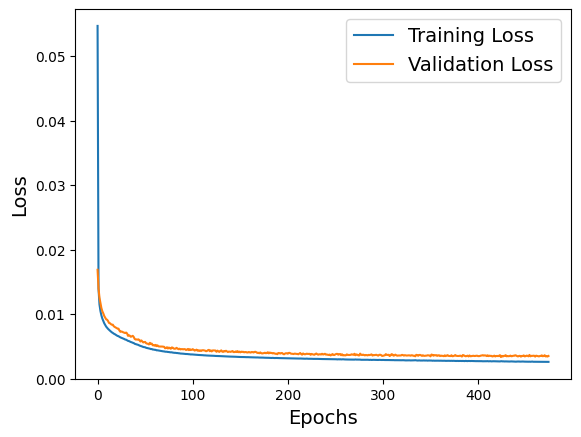

In [64]:
# Plot training and validation loss
plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14_gru = gru_model.predict(X)[0, -1]  # only the last time step's output


1/1 [==============================] - 0s 23ms/step


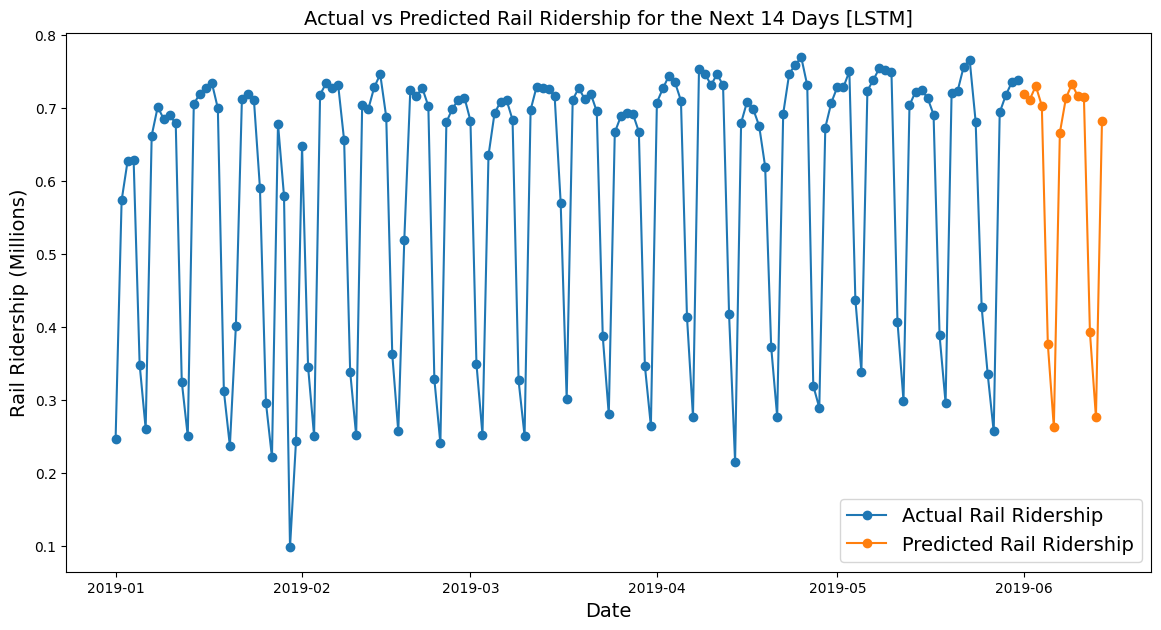

In [66]:
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(rail_valid.index, rail_valid.values, label='Actual Rail Ridership', marker='o')

# Plot predicted values for the next 14 days
predicted_dates = pd.date_range(start=rail_valid.index[-1] + pd.DateOffset(1), periods=14)
plt.plot(predicted_dates, y_pred_14_gru, label='Predicted Rail Ridership', marker='o')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Rail Ridership (Millions)')
plt.title('Actual vs Predicted Rail Ridership for the Next 14 Days [LSTM]')

# Show legend
plt.legend()

# Show the plot
plt.show()